### math 510 project

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [69]:
from heapq import heappush, heappop, heapify

# maxheap built on top of the heapq library
class MaxHeap:

    def __init__(self):
        self.h = []

    def insert(self, x):
        heappush(self.h, -1 * x)

    def remove_min(self):
        if self.h:
            res = -1 * max(self.h)
            self.h.remove(-1 * res)
            heapify(self.h)
            return res
        return 'Empty!'

    def remove_max(self):
        if self.h:
            return -1 * heappop(self.h)
        return 'Empty!'

    def size(self):
        return len(self.h)

    def find_min(self):
        if self.h:
            return -1 * max(self.h)
        return 'Empty!'

    def find_max(self):
        if self.h:
            return -1 * self.h[0]
        return 'Empty!'

# minheap built on top of the heapq library
class MinHeap:

    def __init__(self):
        self.h = []

    def insert(self, x):
        heappush(self.h, x)

    def remove_min(self):
        if self.h:
            return heappop(self.h)
        return 'Empty!'

    def remove_max(self):
        if self.h:
            res = max(self.h)
            self.h.remove(res)
            heapify(self.h)
            return res
        return 'Empty!'

    def size(self):
        return len(self.h)

    def find_min(self):
        if self.h:
            return self.h[0]
        return 'Empty!'

    def find_max(self):
        if self.h:
            return max(self.h)
        return 'Empty!'

def average(a,b):
    s = a + b
    return s / 2.0

def rebalance(l,r):
    if l.size() > r.size() + 1:
        r.insert(l.remove_max())
    elif l.size() < r.size() - 1:
        l.insert(r.remove_min())
    return

# the left and right data structures need to expose the following methods:
#   insert, remove_min, remove_max, find_min, find_max, size
def driver(left_data_structure, right_data_structure, t):
    left = left_data_structure()
    right = right_data_structure()
    
    n = len(t)
    res = []

    # handle the first two integers manually
    first_int = t[0]
    res.append(first_int)

    second_int = t[1]
    res.append(average(first_int, second_int))

    left.insert(min(first_int, second_int))
    right.insert(max(first_int, second_int))

    for x in t[2:]:

        if x > left.find_max():
            right.insert(x)
        else:
            left.insert(x)

        rebalance(left, right)

        if left.size() == right.size():
            res.append(average(left.find_max(), right.find_min()))
        elif left.size() > right.size():
            res.append(left.find_max())
        else:
            res.append(right.find_min())
        
    return res

def running_median(t):
    return driver(MaxHeap, MinHeap, t)

In [70]:
# constants

N = 200         # number of neurons (200)
M = 5           # number of external inputs to the network (?)
T = 1           # total time of the simulation (?)
delta_t = 0.001 # length of the time step (?)
tau = 0.03      # relaxation time constant (0.03)
g = 1.5         # scaling factor (1.5)

In [71]:
# initialize the activations x to uniform noise in the range [-0.1, 0.1]

x = 0.1 * (2 * np.random.rand(N,1) - 1)

In [72]:
# initialize the external inputs

u = np.zeros((M,1))

In [73]:
# initialize the weights J, taken from normal distribution with
# mean 0 and standard deviation g / sqrt(N)

J = np.random.normal(loc=0.0, scale=(g/np.sqrt(N)), size=(N,N))

In [74]:
# initialize the (external) weights B, taken from uniform distribution
# over [-1, 1]

B = 2 * np.random.rand(N,M) - 1

In [75]:
# calculate dx/dt (equation 3, p. 18)
def calculate_response(x):
    return np.tanh(x)

def calculate_derivative(x, u, J, B, tau):
    r = calculate_response(x)
    return (1.0 / tau) * (-x + np.dot(J,r) + np.dot(B,u))

In [76]:
# calculate euler approximation of the time step
def euler_timestep(x, u, J, B, tau, delta_t):
    return x + calculate_derivative(x, u, J, B, tau) * delta_t

In [77]:
def apply_perturbations(x, p, N):
    positions = np.random.rand(N,1) < p
    perturbations = np.random.rand(N,1) - 0.5
    return x + positions * perturbations

In [78]:
def enforce_biases(x):
    x[10][0] = 1.0
    x[11][0] = 1.0
    x[12][0] = -1.0
    return x

In [79]:
# run the simulation of the updates to the excitation

r_s = []  # keep track of resposne(x[0]) over time for the plot
t_s = []  # trial numbers for the plot

for timestep in range(int(round(T/delta_t))):
    x = euler_timestep(x, u, J, B, tau, delta_t)
    r_s.append(calculate_response(x[0][0]))
    t_s.append(timestep)

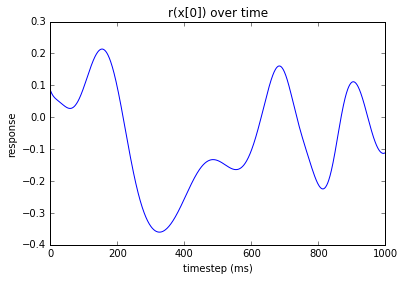

In [80]:
# plot r_s against t_s
plt.plot(t_s, r_s)
plt.title('r(x[0]) over time')
plt.xlabel('timestep (ms)')
plt.ylabel('response')
plt.show()

In [81]:
def update_learning_potential(E, r_prev, x, x_average, N):
    R = np.repeat(r_prev, N).reshape(N,N).transpose()
    X_DIFF = np.repeat(x - x_average, N).reshape(N,N)
    return E + np.power(R * X_DIFF, 3)      

In [82]:
def run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = False):
    E = np.zeros((N,N))  # learning potential
    x_alpha = 0.95       # decay of short-term running average of x
    r_alpha = 0.75       # decay of expected reward
    p = 3.0 / 1000       # probability of perturbation
    
    external = {'A': np.array([1.,0.]).reshape(2,1), 'B': np.array([0.,1.]).reshape(2,1)}
    
    choice1 = random.choice(['A', 'B'])
    choice2 = random.choice(['A', 'B'])
    trial_type = choice1 == choice2
    target_response = -1 if trial_type else 1
    if plot_output: print "Stimulus 1:", choice1
    if plot_output: print "Stimulus 2:", choice2
    u1 = external[choice1]
    u2 = external[choice2]
    u_s = [u1] * 200 + [np.zeros((M,1))] * 200 + [u2] * 200 + [np.zeros((M,1))] * 400
    
    x = 0.1 * (2 * np.random.rand(N,1) - 1)
    x_average = np.zeros((N,1))
    r_prev = calculate_response(x)
    r_s = []
    
    for timestep in range(1000):
        u = u_s[timestep]
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, r_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        r_prev = calculate_response(x)
        r_s.append(r_prev[0][0])
    
    trial_error = sum(map(lambda x: np.abs(target_response - x), r_s[800:])) / 200.0
    trial_reward = trial_error - expected_reward[trial_type]
    prev_expected_reward = expected_reward[trial_type]
    expected_reward[trial_type] = r_alpha * expected_reward[trial_type] + (1 - r_alpha) * trial_error
    
    # return (weight_change, expected_reward, trial_error, r_s) tuple
    return (eta * trial_reward * prev_expected_reward * E, expected_reward, trial_error, r_s)

In [85]:
def task1(num_trials):
    
    N = 200         # number of neurons (200)
    M = 2           # number of external inputs to the network (2)
    T = 1           # total time of the simulation (?)
    delta_t = 0.001 # length of the time step (1 ms)
    tau = 0.03      # relaxation time constant (30 ms)
    g = 1.5         # scaling factor (1.5)
    eta = 0.1       # learning rate (0.5 paper, 0.1 code)
    
    J = np.random.normal(loc=0.0, scale=(g/np.sqrt(N)), size=(N,N))
    B = 2 * np.random.rand(N,M) - 1
    
    expected_reward = {True: 0.0, False: 0.0}
    
    e_s = []
    t_s = []
    
    # plot the output before training
    print "BEFORE TRAINING"
    print "==============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()

    print
    print J
    print
    
    for trial in range(num_trials):
        weight_change, expected_reward, trial_error, _ = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta)
        J -= weight_change
        e_s.append(trial_error)
        t_s.append(trial)
    
    # plot the output before training
    print "AFTER TRAINING"
    print "=============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()
    
    print
    print J
    print
    
    # plot error
    plt.plot(t_s, running_median(e_s))
    plt.title('median trial error over time')
    plt.xlabel('trial')
    plt.ylabel('error')
    plt.show()
    
    return

BEFORE TRAINING
Stimulus 1: B
Stimulus 2: B


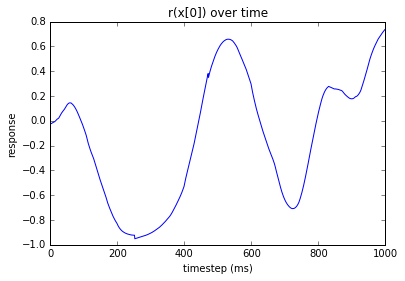


[[-0.04648877  0.02346254  0.20386161 ...,  0.07920585  0.06583948
   0.11453615]
 [ 0.01824426  0.22254006 -0.05740897 ...,  0.09975643  0.0263778
  -0.04836634]
 [-0.08668563  0.0985463   0.11957361 ...,  0.2437207  -0.00211675
   0.05024508]
 ..., 
 [ 0.1635508  -0.00735834  0.02359163 ...,  0.0187483   0.0805936
  -0.04386269]
 [ 0.27257022  0.03918614 -0.02573501 ..., -0.11096438  0.00648658
   0.15860545]
 [ 0.0113399   0.26111249  0.07247003 ..., -0.06254838  0.10352841
   0.09511377]]

AFTER TRAINING
Stimulus 1: B
Stimulus 2: B


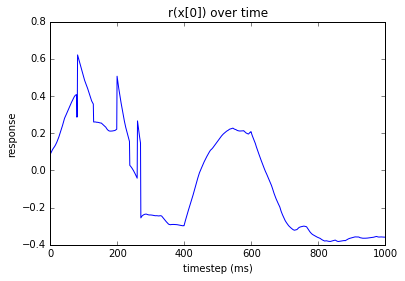


[[-0.05963217  0.03305928  0.19927118 ...,  0.09631825  0.06305091
   0.10707631]
 [ 0.04728952  0.20376541 -0.04946252 ...,  0.06673442  0.02207076
  -0.00783803]
 [-0.06813543  0.08711258  0.09792663 ...,  0.23936688  0.01315013
   0.0556907 ]
 ..., 
 [ 0.18345046  0.0095255  -0.00871299 ..., -0.00028187  0.06395074
  -0.03070309]
 [ 0.2542005   0.05589431 -0.02444213 ..., -0.11544489 -0.03953676
   0.12837132]
 [ 0.03132886  0.23162802  0.10125024 ..., -0.09670105  0.12309711
   0.13930266]]



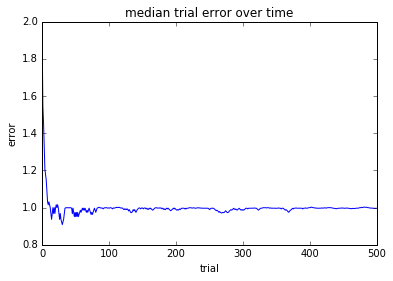

In [87]:
task1(500)